In [1]:
from google.colab import files
import os
#if you've already uploaded kaggle.json before, don't do it again
if not(os.path.exists("kaggle.json")):
  files.upload() #upload kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json


In [2]:
!rm -rf ./data
!kaggle datasets download phylake1337/fire-dataset -p /content/data/dataset-1 --unzip
!kaggle datasets download ashutosh69/fire-and-smoke-dataset -p /content/data/dataset-2 --unzip

 99% 382M/387M [00:02<00:00, 159MB/s]
100% 387M/387M [00:02<00:00, 163MB/s]
 98% 246M/252M [00:03<00:00, 76.7MB/s]
100% 252M/252M [00:03<00:00, 80.9MB/s]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')


import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.applications.vgg16 import VGG16


## Dataset

In [4]:
df = pd.DataFrame(columns=['path','label'])


def populate_df(df, label, paths=[]):
  for path in paths:
    for dirname, _, filenames in os.walk(path):
      for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename), label]],columns=['path','label']))
  return df



df = populate_df(df, 'fire', ['/content/data/dataset-1/fire_dataset/fire_images', '/content/data/dataset-2/data/data/img_data/test/fire', '/content/data/dataset-2/data/data/img_data/train/fire'])
df = populate_df(df, 'neither', ['/content/data/dataset-1/fire_dataset/non_fire_images', '/content/data/dataset-2/data/data/img_data/test/default', '/content/data/dataset-2/data/data/img_data/train/default'])
df = populate_df(df, 'smoke', ['/content/data/dataset-2/data/data/img_data/test/smoke', '/content/data/dataset-2/data/data/img_data/train/smoke'])
#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,/content/data/dataset-2/data/data/img_data/tes...,smoke
1,/content/data/dataset-1/fire_dataset/fire_imag...,fire
2,/content/data/dataset-2/data/data/img_data/tra...,smoke
3,/content/data/dataset-2/data/data/img_data/tra...,fire
4,/content/data/dataset-1/fire_dataset/non_fire_...,neither
5,/content/data/dataset-1/fire_dataset/fire_imag...,fire
6,/content/data/dataset-1/fire_dataset/fire_imag...,fire
7,/content/data/dataset-2/data/data/img_data/tra...,smoke
8,/content/data/dataset-2/data/data/img_data/tra...,fire
9,/content/data/dataset-1/fire_dataset/fire_imag...,fire


In [5]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)


In [6]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,/content/data/dataset-2/data/data/img_data/tes...,smoke,224,224
1,/content/data/dataset-1/fire_dataset/fire_imag...,fire,320,480
2,/content/data/dataset-2/data/data/img_data/tra...,smoke,224,224
3,/content/data/dataset-2/data/data/img_data/tra...,fire,224,224
4,/content/data/dataset-1/fire_dataset/non_fire_...,neither,1200,1600


In [7]:
!pip install xgboost  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
SIZE = 300  #Resize images 

In [9]:
X = []
y = []


for index, row in df.iterrows():
    path = row[0]
    label = row[1]
    img = cv2.imread(path, cv2.IMREAD_COLOR)       
    if img is not None:
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        X.append(img)
        y.append(label)

# Convert lists to arrays        
X = np.array(X)
y = np.array(y)

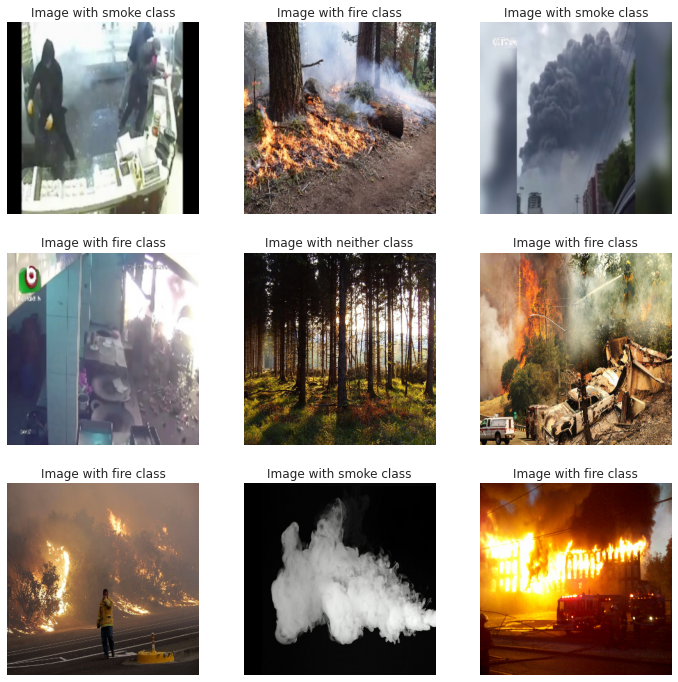

In [10]:
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(X[i])
    ax.axis('off')
    ax.set_title('Image with {} class'.format(y[i]))
    
# display the figure
plt.show()

In [11]:
len(X), len(y)

(2217, 2217)

In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(y)

labels_encoded = le.transform(y)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_encoded, test_size=0.20, random_state=42)

In [14]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [15]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

In [16]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [17]:

#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(X_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF


In [18]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train) # For sklearn no one hot encoding


XGBClassifier(objective='multi:softprob')

In [19]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [20]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)

In [21]:


#Inverse le transform to get original label back. 
pred = le.inverse_transform(prediction)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

Accuracy =  0.8423423423423423


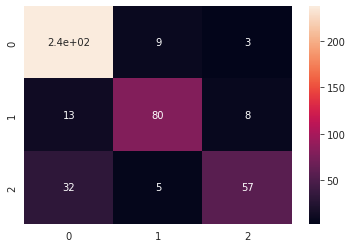

In [36]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

<--------- Run this block again to see another image test --------->
The prediction for this image is:  ['fire']
The actual label for this image is:  0


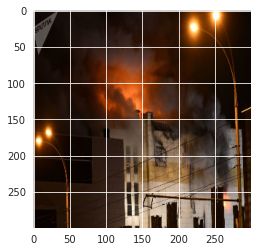

In [39]:

#Check results on a few select images
n=np.random.randint(0, X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
p = model.predict(input_img_features)[0] 
p = le.inverse_transform([p])  #Reverse the label encoder to original name
print("<--------- Run this block again to see another image test --------->")
print("The prediction for this image is: ", p)
print("The actual label for this image is: ", y_test[n])

In [25]:
from sklearn.metrics import f1_score, classification_report


print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       249
           1       0.85      0.79      0.82       101
           2       0.84      0.61      0.70        94

    accuracy                           0.84       444
   macro avg       0.84      0.78      0.81       444
weighted avg       0.84      0.84      0.84       444



### Testing on new data

In [61]:
def inferenceing_function(img_path):
    
    def image_display(img):
        
        plt.figure(figsize=(30, 6))
        plt.imshow(img)
        plt.yticks([])
        plt.xticks([])
        plt.show()
    
    def model_inference_results():
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
      
      image_display(img)
      img = cv2.resize(img, (SIZE, SIZE))
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

      input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
      input_img_feature = VGG_model.predict(input_img)
      input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
      p = model.predict(input_img_features)[0] 
      p = le.inverse_transform([p])  #Reverse the label encoder to original name
      print("The prediction for this image is: ", p)
            
    
    
    return (model_inference_results())

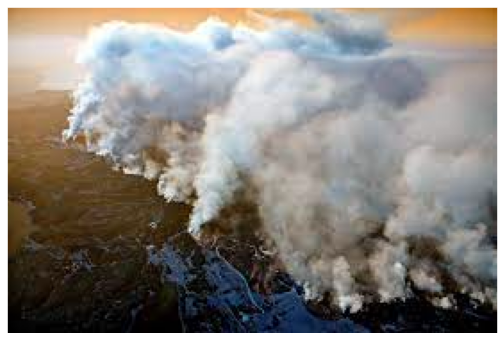

The prediction for this image is:  ['smoke']


In [67]:
inferenceing_function("/content/data/smoke.jpeg")

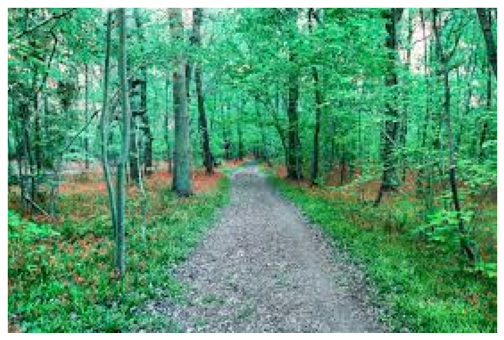

The prediction for this image is:  ['neither']


In [65]:
inferenceing_function("/content/data/woods.jpeg")

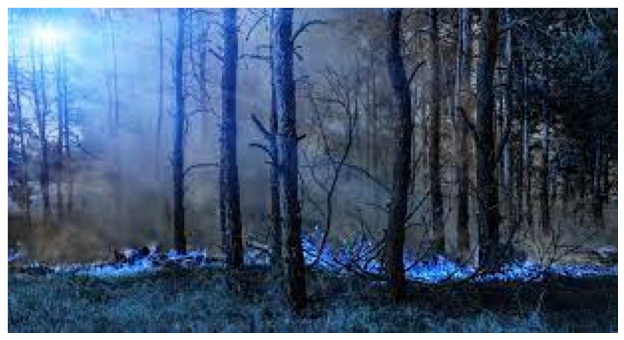

The prediction for this image is:  ['fire']


In [66]:
inferenceing_function("/content/data/fire.jpeg")